# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Example 1

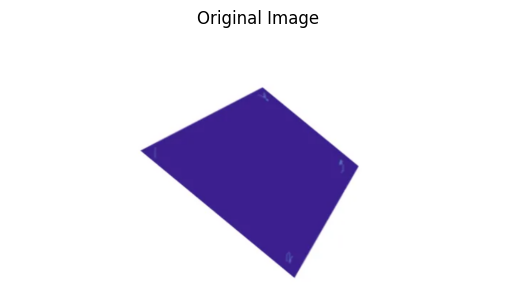

In [2]:
image = cv2.imread('images/eg_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.title('Original Image');
plt.axis('off');
plt.show();

# Corner Detection (Shi-Tomasi)

In [3]:
def shi_tomashi(image):
    """
    Use Shi-Tomashi algorithm to detect corners
    Args:
        image: np.array
    Returns:
        corners: list
    """
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,4,0.01,100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print('\n The corners points are ... \n')
    img = image.copy()
    for index, c in enumerate(corners):
        x,y = c
        cv2.circle(img, (x,y), 3, 255, -1)
        character = chr(65 + index)
        print(f'{character} : {c}')
        cv2.putText(img, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX,1 ,(0,255,255),2 ,cv2.LINE_AA)
    plt.imshow(img)
    plt.title('Corner Detection: Shi-Tomashi')
    plt.show()
    return corners


 The corners points are ... 

A : [230, 207]
B : [442, 97]
C : [498, 428]
D : [610, 235]


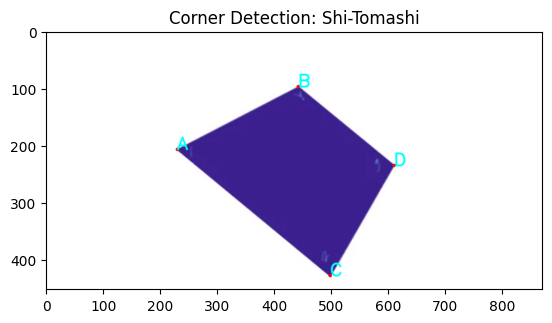

In [4]:
corners = shi_tomashi(image)

# Get Destination Points

In [5]:
def get_destination_points(corners):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
    Args:
        corners: list
    Returns:
        destination_corners: list
        height: int
        width: int
    """

    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
    
    print('\nThe destination points are: \n')
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))
    return destination_corners, h, w

In [6]:
destination, h, w = get_destination_points(corners)
destination


The destination points are: 

A' : [0. 0.]
B' : [237.   0.]
C' : [  0. 346.]
D' : [237. 346.]

The approximated height and width of the original image is: 
 (347, 238)


array([[  0.,   0.],
       [237.,   0.],
       [  0., 346.],
       [237., 346.]], dtype=float32)

# Homographic calculation and perspective transform

In [7]:
def unwrap(img,src,dst):
    """
    Args:
        img: np.array
        src: list
        dst: list
    Returns:
        un_warped: np.array
    """
    h,w = img.shape[:2]
    H,_ = cv2.findHomography(src, dst, method = cv2.RANSAC, ransacReprojThreshold = 3.0)
    print(f'\n The homography matrix is : \n {H}')
    un_wraped = cv2.warpPerspective(img, H, (w,h), flags = cv2.INTER_LINEAR)

    # plot

    f,(ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img)
    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
    ax1.plot(x, y, color = 'yellow', linewidth = 3)
    ax1.set_ylim([h, 0])
    ax1.set_xlim([0, w])
    ax1.set_title('Targeted Area in Original Image')
    ax2.imshow(un_wraped)
    ax2.set_title('Unwarped Image')
    plt.show()
    return un_wraped


 The homography matrix is : 
 [[ 4.40836990e-01 -5.34589653e-01  9.26755048e+00]
 [ 5.13198446e-01  9.89073368e-01 -3.22773830e+02]
 [-1.10645415e-03  1.35577021e-03  1.00000000e+00]]


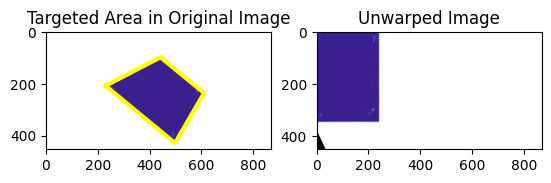

In [8]:
unwrapped = unwrap(image,np.float32(corners),destination)

# Example 2

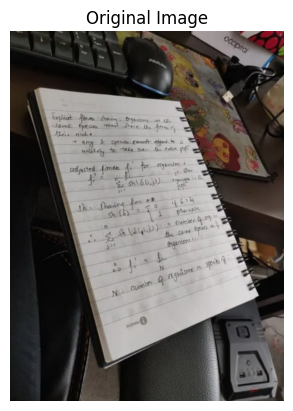

In [9]:
image = cv2.imread('images/eg_2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Original Image');
plt.axis('off');
plt.show();

# Masking Thresholding and Contour Detection

In [10]:
def apply_filter(image):
    """
    Define a 5X5 kernel and apply the filter to gray scale image
    Args:
        image: np.array
    Returns:
        filtered: np.array
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5,5), np.float32) / 15
    filtered = cv2.filter2D(gray, -1, kernel)
    plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
    plt.title('Filtered Image')
    plt.show()
    return filtered

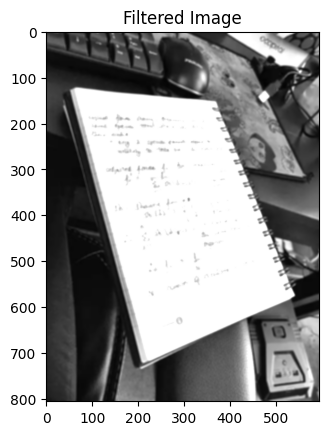

In [11]:
filtered = apply_filter(image)

# Otshu

In [12]:
def apply_threshold(filtered):
    """
    Apply OTSU threshold
    Args:
        filtered: np.array
    Returns:
        thresh: np.array
    """
    ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_OTSU)    
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.title('After applyiing OTSU threshold')
    plt.show()
    return thresh

def detect_contour(img, image_shape):
    """
    Args:
        img: np.array()
        image_shape: tuple
    Returns:
        canvas: np.array()
        cnt: list
    """
    canvas = np.zeros(image_shape, np.uint8)
    contours, hierachy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(canvas, cnt, -1, (0,255,255), 3)
    plt.title('Largest Contour')
    plt.imshow(canvas)
    plt.show()

    return canvas,cnt

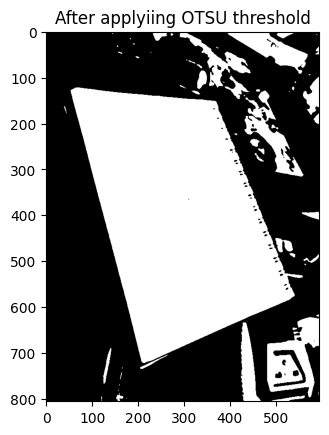

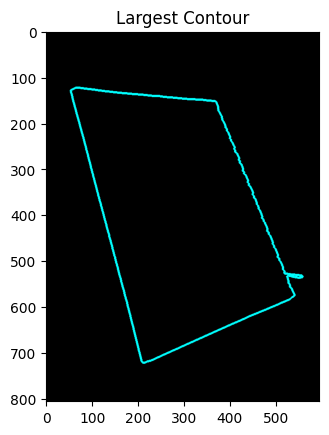

In [13]:
thresholded = apply_threshold(filtered)
canvas, largest_contour = detect_contour(thresholded,image.shape)

# Corner Detection (using Douglas-Peucker algorithm)

In [14]:
def detect_corners_from_contour(canvas,cnt):
    """
    Detecting corner points form contours using cv2.approxPolyDP()
    Args:
        canvas: np.array()
        cnt: list
    Returns:
        approx_corners: list
    """
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
    approx_corners = sorted(np.concatenate(approx_corners).tolist())
    print('\nThe corner points are ...\n')
    for index, c in enumerate(approx_corners):
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(canvas, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Rearranging the order of the corner points
    approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]

    plt.imshow(canvas)
    plt.title('Corner Points')
    plt.show()
    return approx_corners


The corner points are ...

A : [54, 128]
B : [210, 722]
C : [369, 153]
D : [540, 576]


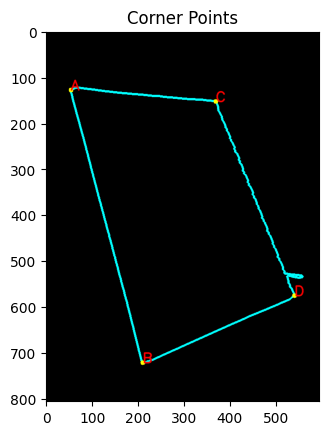

In [15]:
corners = detect_corners_from_contour(canvas, largest_contour)

# Homography calculation and perspective transform


The destination points are: 

A' : [0. 0.]
B' : [359.   0.]
C' : [  0. 613.]
D' : [359. 613.]

The approximated height and width of the original image is: 
 (614, 360)

 The homography matrix is : 
 [[ 9.14071235e-01 -2.40059112e-01 -1.86322803e+01]
 [-1.11442362e-01  1.40417377e+00 -1.73716355e+02]
 [-8.78565121e-04  7.15774781e-04  1.00000000e+00]]


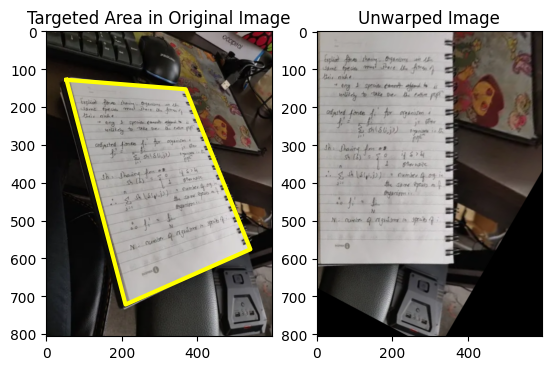

In [16]:
destination, h, w = get_destination_points(corners)
unwrapped = unwrap(image,np.float32(corners),destination)